# CIB Portfolio Process

In [2]:
import Quandl
import numpy as np
import pandas as pd
import math
import scipy
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import os
import random
import datetime

%matplotlib inline  
pd.options.display.mpl_style = 'default'
pylab.rcParams['figure.figsize'] = 12, 6 

In [3]:
def get(ticker_list, kind = 'log_returns'):
    #takes in a ticker list and returns either a dataframe of closing price 'returns'
    #for each stock or closing 'prices'
    final_df = pd.DataFrame()
    for item in ticker_list:
        ticker = item
        temp_df = Quandl.get('YAHOO/'+str(ticker), 
                                         trim_start='2001-01-01', authtoken="H4uWGQ3jQdm96V7H2Abm")
        temp_df.index = pd.to_datetime(temp_df.index)
        temp_df = temp_df.sort()
        if (kind == 'prices'):
            add_series = temp_df.Close
        elif (kind == 'log_prices'):
            add_series = np.log(temp_df.Close);
        elif (kind == 'returns'):
            add_series = temp_df.Close.shift(-1) - temp_df.Close
        else:
            add_series = np.log(temp_df.Close).shift(-1) - np.log(temp_df.Close)
        final_df[ticker] = add_series
        

    final_df = final_df.sort()
    return final_df


## Markowitz Efficient Portfolio Calculations

In [4]:
def portfolio_sharpe(return_df, weight_list):
    risk = float(portfolio_risk(return_df, weight_list))
    weight_t = np.matrix(weight_list)
    mean = np.matrix(return_df.mean()).transpose()
    sharpe = weight_t * mean / risk
    return float(sharpe)

def portfolio_e_return(return_df, weight_list):
    weight_t = np.matrix(weight_list)
    mean = np.matrix(return_df.mean()).transpose()
    return float(weight_t * mean)

def portfolio_risk(return_df, weight_list):
    #Take in a PRICE_DF with columns being each stock's daily log_returns
    #Take in WEIGHT_LIST with each list entry corresponding to the respective price_df
    #column's weight in the portfolio
    #PRICE_DF should be a concatenation of return series from return_series()
    if (abs(sum(weight_list) - 1) > .01):
        print("EROR: Weights do not sum to 1");
        return None
    cov_matrix = np.matrix(return_df.cov())
    weight_t = np.matrix(weight_list)
    weight = weight_t.transpose()
    variance = weight_t * cov_matrix * weight
    return float(variance)

In [5]:
def efficient_frontier_plot(portfolio, n_obs):
    count = 0
    xyw = pd.DataFrame([[None,None]])
    while count < n_obs:
        weight_list = [random.uniform(0, 1) for i in range(1, len(portfolio.columns) + 1)]
        
        weight_list = [item / float(sum(weight_list)) for item in weight_list]
        risk = portfolio_risk(portfolio, weight_list)
        e_return = portfolio_e_return(portfolio, weight_list)
        xyw = xyw.append([[math.sqrt(risk), e_return, weight_list]])
        
        count += 1
    xyw.columns = ['x', 'y', 'w']
    xyw['sharpe'] = xyw.y / xyw.x
    xyw['y'] = xyw.y * 100
    xyw.plot(title = "Efficient Frontier from " + str(n_obs) + 
             " Sample Portfolios", kind = 'scatter', y = 'y', x = 'x')
    plt.figure()
    plt.title("Histogram of Sample Sharpe Ratios\nMean: "+str(xyw.sharpe.mean()) + "\nSD: " + str(xyw.sharpe.std()))
    xyw.sharpe.hist(bins = 50)
    plt.figure()
    plt.title("Histogram of Sample Portfolio Variances\nMean: "+str(xyw.x.mean()) + "\nSD: " + str(xyw.x.std()))
    xyw.x.hist(bins = 50)
    plt.figure()
    plt.title("Histogram of Sample Portfolio Mean Returns\nMean: "+str((xyw.y / 100).mean()) + "\nSD: " + str((xyw.y / 100).std()))
    xyw.y.hist(bins = 50)
    return xyw

In [6]:
def find_tangency_portfolio(portfolio, n_obs):
    #finds tangency portfolio weights from n_obs number of samples
    temp = efficient_frontier_plot(portfolio, n_obs)
    return temp[temp.sharpe == temp.sharpe.max()].w[0]

def find_optimal_portfolios(portfolio, n_obs, quantile_start, quantile_end):
    #returns efficient frontier dataframe with only portfolio weights with 
    #a sharpe between the qth_start and qth_end quantile
    temp = efficient_frontier_plot(portfolio, n_obs)
    qth_start = find_quantile(temp.sharpe, quantile_start)
    qth_end = find_quantile(temp.sharpe, quantile_end)

    temp = temp[temp.sharpe < qth_end]
    temp = temp[temp.sharpe > qth_start]
    return temp



## Statistical Functions 

In [7]:
def find_quantile(series, qth_percentile):
    #returns the qth percentile element of the input series
    #qth percentile = 95 takes the 95% quantile
    return np.percentile(series, qth_percentile)

def qq_plot(return_series, distribution = 'norm'):
    scipy.stats.probplot(return_series, dist=distribution, plot=pylab, fit = True)

def histogram(series):
    series.hist()
    pylab.suptitle("Samples = " + str(len(series)) + 
               "\nMean = " + str(series.mean()) + 
               "\nSTD = " + str(series.std()))
    
    

## Fundamental Analysis

In [8]:
def get_eps(ticker_list):
    final_df = pd.DataFrame()
    for ticker in ticker_list:
        try:
            temp_df = Quandl.get("SEC/" + ticker + "_EARNINGSPERSHAREDILUTED_Q", 
                                         authtoken="H4uWGQ3jQdm96V7H2Abm")
        except:
            print("WARNING: Could not find EPS for " + ticker)
            continue;
        temp_df.columns = [ticker]
        if not final_df.equals(pd.DataFrame()):
            final_df = pd.merge(final_df, temp_df, left_index = True, right_index = True,  how = 'outer')
        else:
            final_df = temp_df
    final_df = final_df.fillna(method = 'ffill')
    return final_df

def get_debt_ratio(ticker_list):
    final_df = pd.DataFrame()
    for ticker in ticker_list:
        try:
            temp_df = Quandl.get("SEC/" + ticker + "_DEBTINSTRUMENTADJUSTEDDEBTRATIO_Q", 
                                         authtoken="H4uWGQ3jQdm96V7H2Abm")
        except:
            print("WARNING: Could not find debt ratio for " + ticker)
            continue;
        temp_df.columns = [ticker]
        if not final_df.equals(pd.DataFrame()):
            final_df = pd.merge(final_df, temp_df, left_index = True, right_index = True,  how = 'outer')
        else:
            final_df = temp_df
    final_df = final_df.fillna(method = 'ffill')
    return final_df


def get_div(ticker_list):
    final_df = pd.DataFrame()
    for ticker in ticker_list:
        try:
            temp_df = Quandl.get(("SEC/DIV_" + ticker), 
                                         authtoken="H4uWGQ3jQdm96V7H2Abm")
        except:
            print("WARNING: Could not find DIV for " + ticker)
            continue;
        temp_df.columns = [ticker]
        if not final_df.equals(pd.DataFrame()):
            final_df = pd.merge(final_df, temp_df, left_index = True, right_index = True,  how = 'outer')
        else:
            final_df = temp_df
    final_df = final_df.fillna(method = 'ffill')    
    return final_df

In [9]:
def ally_df(ticker):
    #returns latest eps and dividend for each date
    #the first column is daily returns for the stock
    price_df = get([ticker])
    eps_df = get_eps([ticker])
    div_df = get_div([ticker])
    final_df = pd.merge(price_df, eps_df, right_index = True, left_index = True, how = 'left')
    final_df = pd.merge(final_df, div_df, right_index = True, left_index = True, how = 'left')
    final_df.columns = [ticker, 'EPS', 'DIV']
    final_df.EPS = final_df.EPS.fillna(method = 'ffill')
    final_df.DIV = final_df.DIV.fillna(method = 'ffill')
    return final_df

def div_dis_model(ticker, discount_rate):
    temp = ally_df(ticker)


    temp = temp.fillna(0)
    temp['place'] = np.where(temp.DIV != temp.DIV.shift(1), 1, 0)

    temp['exp'] = temp.place.cumsum()
    temp['series_entry'] = np.where(temp.DIV != temp.DIV.shift(1), temp.DIV / (1 + discount_rate) ** (temp.exp), 0)
    answer = temp.series_entry.sum()  
    return answer

In [18]:
get_debt_ratio(['CAKE', 'FB'])

,CAKE
Date,
2011-06-28,2.8
2011-09-27,2.8
2012-01-03,2.7
2012-04-03,2.7
2012-07-03,2.7
2012-10-02,2.7
2013-01-01,2.7
2013-04-02,2.7
2013-07-02,2.7


## Get S&P 500 Tickers

In [32]:
def get_sp500():
    temp = pd.read_csv("data/sp500_tickers.csv")
    temp.columns = ['ticker', 'name', 'sector']
    temp = temp[temp.ticker != 'ICE']
    return temp


## >> CODE TESTING

In [63]:
temp = get(['AAPL', 'IBM', 'GE', 'BA'], 'log_returns')

In [73]:
#Get log returns dataframe
temp = get(['AAPL', 'IBM', 'GE', 'BA'], 'log_returns')
#Make mean return vector
mean = np.matrix(temp.mean()).transpose()
#Make weight vector
w = np.matrix([.4, .2, .1, .3])
#Make Covaraince matrix of returns
np.matrix(temp.cov())

matrix([[ 0.00172632,  0.00017263,  0.00019241,  0.00015067],
        [ 0.00017263,  0.00024332,  0.00016244,  0.00012195],
        [ 0.00019241,  0.00016244,  0.00038269,  0.00019067],
        [ 0.00015067,  0.00012195,  0.00019067,  0.00035773]])

In [ ]:
mean = np.matrix(return_df.mean()).transpose()

In [44]:
a=get_sp500()
temp = [a for a in a.ticker]
temp = ally_df('IBM')


In [60]:
temp = ally_df('IBM')


temp = temp.fillna(0)
temp['place'] = np.where(temp.DIV != temp.DIV.shift(1), 1, 0)

temp['exp'] = temp.place.cumsum()
temp['series_entry'] = np.where(temp.DIV != temp.DIV.shift(1), temp.DIV / (1 + .05) ** (temp.exp), 0)
answer = temp.series_entry.sum()
answer

4.5705690082486017

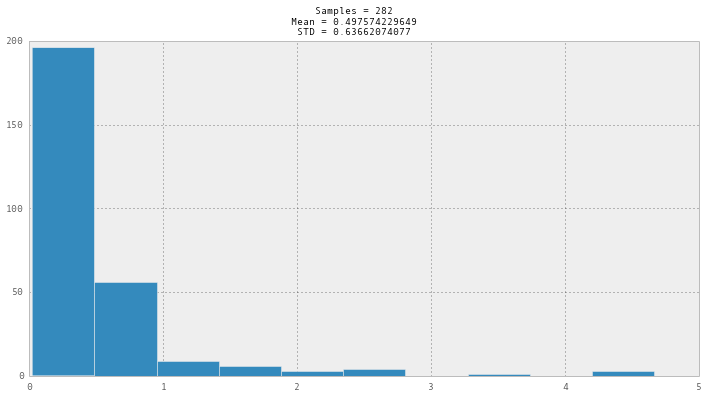

In [102]:
histogram(eps_df.std())

In [4]:
portfolio = get(['msft', 'mu', 'f', 'gs', 'ge', 'cvx', 'gs', 'ups', 'luv'], 'log_returns')

In [16]:
portfolio_sharpe(portfolio, [.2, .2, .4, .2])


-0.11761119743087618